# Part 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Load Fashion MNIST dataset
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, parser='auto')
X = fashion_mnist.data.astype('float32') / 255.0  # Normalize pixel values
y = fashion_mnist.target.astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (56000, 784), (56000,)
Test set: (14000, 784), (14000,)


# Convert DataFrames to NumPy arrays for simpler indexing


In [3]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (56000, 784), (56000,)
Test set: (14000, 784), (14000,)


#  Baseline - Training a Classifier with Limited Labels
establish a baseline by training a logistic regression classifier with only a small number of labeled examples

In [4]:
# Select only a small subset of labeled examples
n_labeled = 100  # 10 examples per class on average for the 10 classes

# Train a logistic regression model on the limited labeled data
log_reg = LogisticRegression(max_iter=5000, multi_class='multinomial', random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

# Evaluate the model on the test set
baseline_score = log_reg.score(X_test, y_test)
print(f"Baseline accuracy with {n_labeled} labeled examples: {baseline_score:.4f}")

Baseline accuracy with 100 labeled examples: 0.6551


# Semi-Supervised Learning with K-Means Clustering

In [5]:
# Function to perform semi-supervised learning via clustering
def run_semi_supervised_experiment(X_train, y_train, X_test, y_test, n_clusters, percentile_closest=None):
    # Step 1: Run K-Means clustering on the training data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    X_distances = kmeans.fit_transform(X_train)

    # Step 2: Find representative images (closest to centroids)
    representative_indices = np.argmin(X_distances, axis=0)
    X_representatives = X_train[representative_indices]
    y_representatives = y_train[representative_indices]

    # Step 3: Train classifier on representative examples
    log_reg_repr = LogisticRegression(max_iter=5000, multi_class='multinomial', random_state=42)
    log_reg_repr.fit(X_representatives, y_representatives)
    repr_score = log_reg_repr.score(X_test, y_test)

    # Step 4: Propagate labels to all cluster members
    y_propagated = np.zeros(len(X_train), dtype=int)
    for i in range(n_clusters):
        y_propagated[kmeans.labels_ == i] = y_representatives[i]

    # Step 5: Train classifier on all propagated data
    log_reg_full = LogisticRegression(max_iter=5000, multi_class='multinomial', random_state=42)
    log_reg_full.fit(X_train, y_propagated)
    full_score = log_reg_full.score(X_test, y_test)

    # Step 6: Optional – Train on only closest instances in each cluster
    partial_score = None
    if percentile_closest is not None:
        instance_distances = X_distances[np.arange(len(X_train)), kmeans.labels_]
        partially_propagated = np.zeros(len(X_train), dtype=bool)
        for i in range(n_clusters):
            in_cluster = (kmeans.labels_ == i)
            cluster_distances = instance_distances[in_cluster]
            cutoff = np.percentile(cluster_distances, percentile_closest)
            partially_propagated[in_cluster] = (instance_distances[in_cluster] <= cutoff)

        X_partial = X_train[partially_propagated]
        y_partial = y_propagated[partially_propagated]
        log_reg_partial = LogisticRegression(max_iter=5000, multi_class='multinomial', random_state=42)
        log_reg_partial.fit(X_partial, y_partial)
        partial_score = log_reg_partial.score(X_test, y_test)

    return {
        'representatives_only': repr_score,
        'full_propagation': full_score,
        'partial_propagation': partial_score
    }

# Run experiments for various numbers of clusters
cluster_counts = [50, 100, 200]
results = {}

for k in cluster_counts:
    print(f"\nRunning experiment with k={k} clusters...")
    results[k] = run_semi_supervised_experiment(X_train, y_train, X_test, y_test,
                                                n_clusters=k, percentile_closest=20)
    print(f"Accuracy with {k} representatives only: {results[k]['representatives_only']:.4f}")
    print(f"Accuracy with full label propagation: {results[k]['full_propagation']:.4f}")
    print(f"Accuracy with partial label propagation (20%): {results[k]['partial_propagation']:.4f}")


Running experiment with k=50 clusters...


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy with 50 representatives only: 0.6732
Accuracy with full label propagation: 0.6686
Accuracy with partial label propagation (20%): 0.6674

Running experiment with k=100 clusters...


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy with 100 representatives only: 0.6997
Accuracy with full label propagation: 0.6968
Accuracy with partial label propagation (20%): 0.6959

Running experiment with k=200 clusters...


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy with 200 representatives only: 0.7604
Accuracy with full label propagation: 0.7605
Accuracy with partial label propagation (20%): 0.7464


# visualize some of the representative examples chosen by the K-Means algorithm


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


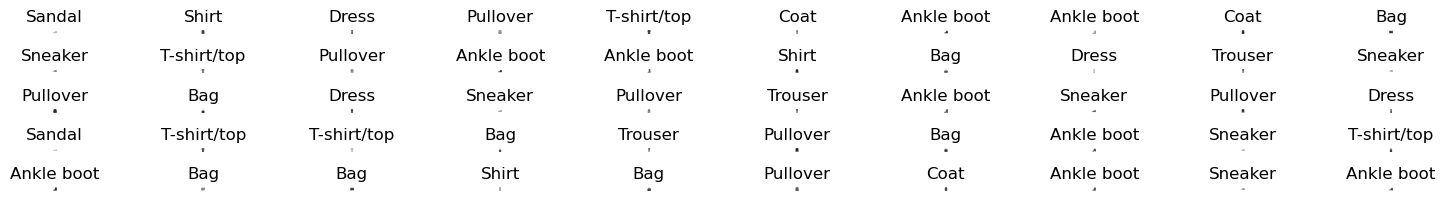

In [6]:
def plot_representatives(X_representatives, y_representatives, n_clusters=50, figsize=(15, 8)):
    plt.figure(figsize=figsize)
    
    # Determine number of rows and columns for the plot
    n_rows = int(np.ceil(n_clusters / 10))
    
    # Fashion MNIST class names
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    for i in range(min(n_clusters, 50)):  # Show at most 50 examples
        plt.subplot(n_rows, 10, i + 1)
        plt.imshow(X_representatives[i].reshape(28, 28), cmap='binary')
        plt.title(f"{class_names[y_representatives[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run K-Means with the best k value from our experiments
best_k = max(results, key=lambda k: results[k]['partial_propagation'])
kmeans = KMeans(n_clusters=best_k, random_state=42)
X_distances = kmeans.fit_transform(X_train)
representative_indices = np.argmin(X_distances, axis=0)
X_representatives = X_train[representative_indices]
y_representatives = y_train[representative_indices]

# Plot representative examples
plot_representatives(X_representatives, y_representatives, n_clusters=best_k)

# Part 2: 
Semi-Supervised Learning with Overhead MNIST

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

# === Step 1: Load the data ===
data = pd.read_csv(r"E:\Ketaki S\CMI stuff\DMML\Ass_3_data\overhead\train.csv")
X = data.iloc[:, 1:].values.astype('float32') / 255.0  # Normalize pixel values
y = data.iloc[:, 0].values.astype(int)

# Split into train and test sets (80-20)
X_oh_train, X_oh_test, y_oh_train, y_oh_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 2: Baseline with 100 labeled examples ===
n_labeled_oh = 100
log_reg_oh = LogisticRegression(max_iter=5000, multi_class='multinomial', random_state=42)
log_reg_oh.fit(X_oh_train[:n_labeled_oh], y_oh_train[:n_labeled_oh])
baseline_score_oh = log_reg_oh.score(X_oh_test, y_oh_test)
print(f"Overhead MNIST - Baseline accuracy with {n_labeled_oh} labeled examples: {baseline_score_oh:.4f}")

# === Step 3: Define semi-supervised experiment ===
def run_semi_supervised_experiment(X_train, y_train, X_test, y_test, n_clusters=100, percentile_closest=20):
    # Step 1: Cluster the training data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train)
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_

    # Step 2: For each cluster, find the closest labeled point (pseudo-labeling)
    representative_indices = []
    for i in range(n_clusters):
        cluster_points = np.where(cluster_labels == i)[0]
        if len(cluster_points) == 0:
            continue
        center = cluster_centers[i].reshape(1, -1)
        dists = cdist(X_train[cluster_points], center)
        closest_idx = cluster_points[np.argmin(dists)]
        representative_indices.append(closest_idx)

    # Get representative samples
    X_reps = X_train[representative_indices]
    y_reps = y_train[representative_indices]

    # Train on representatives only
    model_reps = LogisticRegression(max_iter=5000, multi_class='multinomial', random_state=42)
    model_reps.fit(X_reps, y_reps)
    acc_reps = model_reps.score(X_test, y_test)

    # Step 3: Full label propagation — assign all cluster points the label of their representative
    y_train_fullprop = np.zeros_like(y_train)
    for i, rep_idx in enumerate(representative_indices):
        cluster_points = np.where(cluster_labels == i)[0]
        y_train_fullprop[cluster_points] = y_train[rep_idx]

    model_fullprop = LogisticRegression(max_iter=5000, multi_class='multinomial', random_state=42)
    model_fullprop.fit(X_train, y_train_fullprop)
    acc_fullprop = model_fullprop.score(X_test, y_test)

    # Step 4: Partial label propagation — only assign to closest X% in each cluster
    y_train_partial = np.copy(y_train)
    for i, rep_idx in enumerate(representative_indices):
        cluster_points = np.where(cluster_labels == i)[0]
        center = cluster_centers[i].reshape(1, -1)
        dists = cdist(X_train[cluster_points], center).flatten()
        k = max(1, int(len(dists) * (percentile_closest / 100)))
        top_k_indices = cluster_points[np.argsort(dists)[:k]]
        y_train_partial[top_k_indices] = y_train[rep_idx]

    model_partial = LogisticRegression(max_iter=5000, multi_class='multinomial', random_state=42)
    model_partial.fit(X_train, y_train_partial)
    acc_partial = model_partial.score(X_test, y_test)

    return {
        "representatives_only": acc_reps,
        "full_propagation": acc_fullprop,
        "partial_propagation": acc_partial
    }

# === Step 4: Run for different k values ===
cluster_counts_oh = [50, 100, 200]
results_oh = {}

for k in cluster_counts_oh:
    print(f"\nOverhead MNIST - Running experiment with k={k} clusters...")
    results_oh[k] = run_semi_supervised_experiment(X_oh_train, y_oh_train, X_oh_test, y_oh_test,
                                                   n_clusters=k, percentile_closest=20)
    print(f"Accuracy with {k} representatives only: {results_oh[k]['representatives_only']:.4f}")
    print(f"Accuracy with full label propagation: {results_oh[k]['full_propagation']:.4f}")
    print(f"Accuracy with partial label propagation (20%): {results_oh[k]['partial_propagation']:.4f}")


Overhead MNIST - Baseline accuracy with 100 labeled examples: 0.3011

Overhead MNIST - Running experiment with k=50 clusters...


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy with 50 representatives only: 0.2465
Accuracy with full label propagation: 0.2723
Accuracy with partial label propagation (20%): 0.4507

Overhead MNIST - Running experiment with k=100 clusters...


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy with 100 representatives only: 0.3245
Accuracy with full label propagation: 0.3187
Accuracy with partial label propagation (20%): 0.4413

Overhead MNIST - Running experiment with k=200 clusters...


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy with 200 representatives only: 0.3756
Accuracy with full label propagation: 0.3357
Accuracy with partial label propagation (20%): 0.4478


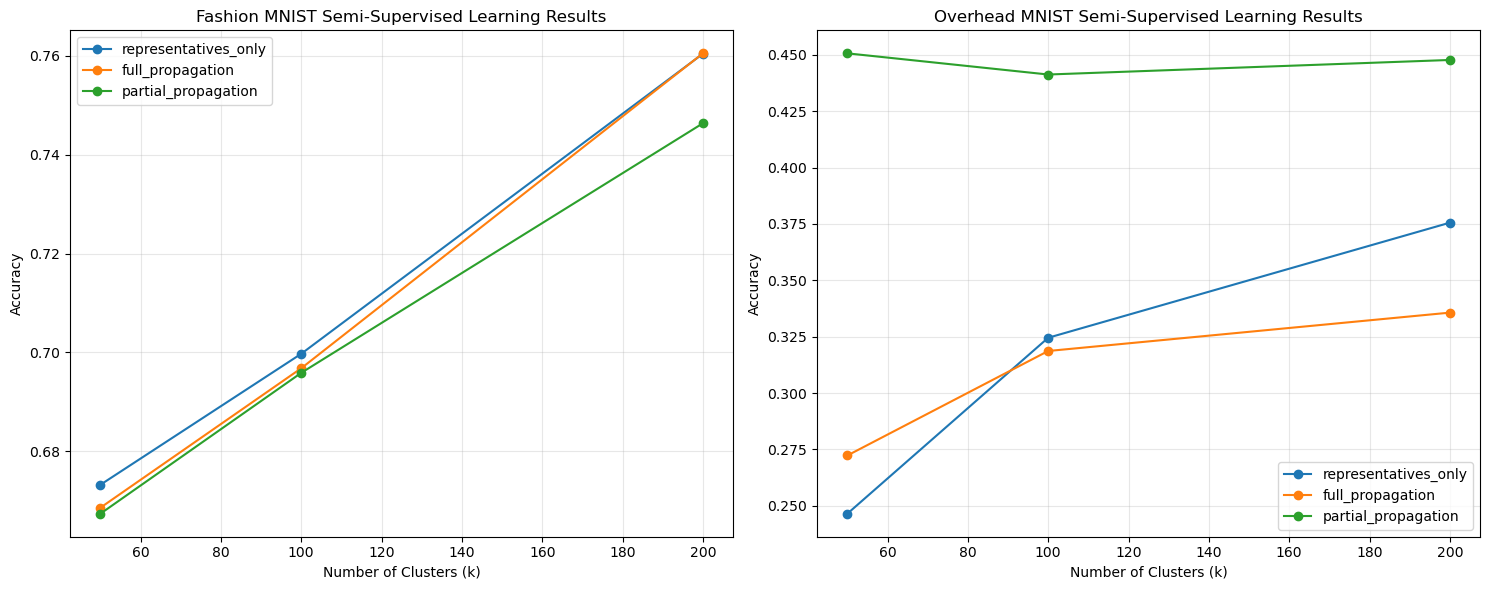

In [11]:
def plot_results_comparison(fashion_results, overhead_results, cluster_counts):
    plt.figure(figsize=(15, 6))
    
    # Plot results for Fashion MNIST
    plt.subplot(1, 2, 1)
    for result_type in ['representatives_only', 'full_propagation', 'partial_propagation']:
        plt.plot(cluster_counts, 
                 [fashion_results[k][result_type] for k in cluster_counts], 
                 marker='o', 
                 label=result_type)
    
    plt.title('Fashion MNIST Semi-Supervised Learning Results')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot results for Overhead MNIST
    plt.subplot(1, 2, 2)
    for result_type in ['representatives_only', 'full_propagation', 'partial_propagation']:
        plt.plot(cluster_counts, 
                 [overhead_results[k][result_type] for k in cluster_counts], 
                 marker='o', 
                 label=result_type)
    
    plt.title('Overhead MNIST Semi-Supervised Learning Results')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot comparison of results
plot_results_comparison(results, results_oh, cluster_counts)